In [1]:
!gdown --id 1c8k6cQ0P9HgkfoxgZx5jbn6e-6v0JRTO

/home/arpan/miniconda3/envs/prog/lib/python3.10/site-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1c8k6cQ0P9HgkfoxgZx5jbn6e-6v0JRTO
From (redirected): https://drive.google.com/uc?id=1c8k6cQ0P9HgkfoxgZx5jbn6e-6v0JRTO&confirm=t&uuid=c6e19964-4465-4762-9264-b169fe1102fc
To: /home/arpan/prog-rock/training_data.zip
100%|██████████████████████████████████████| 2.51G/2.51G [00:28<00:00, 88.0MB/s]


In [2]:
!mkdir content
!unzip -j training_data.zip -d ./content

# we have the data


mkdir: cannot create directory ‘content’: File exists
Archive:  training_data.zip
  inflating: ./content/non_progressive_rock_songs_tensor.pt  
  inflating: ./content/progressive_rock_songs_tensor.pt  


In [3]:
import torch
from torchsummary import summary

#training tensors
prog_tensors = torch.load('./content/progressive_rock_songs_tensor.pt')
non_prog_tensors = torch.load('./content/non_progressive_rock_songs_tensor.pt')

def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
print(" CUDA Version is ", get_device())

 CUDA Version is  cuda:0


In [6]:
prog_tensors = prog_tensors.float()
non_prog_tensors = non_prog_tensors.float()

In [7]:
data = torch.cat((prog_tensors, non_prog_tensors), dim=0)
labels = torch.cat((torch.ones(prog_tensors.shape[0]), torch.zeros(non_prog_tensors.shape[0])), dim=0)

In [4]:
batch_size = 32 

In [8]:
from torch.utils.data import TensorDataset, DataLoader

# Create TensorDataset from your data and labels
train_dataset = TensorDataset(data, labels)
# Create DataLoader for each dataset with the specified batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


## Model 

In [9]:
import torch
import torch.nn as nn

class MyConvNet(nn.Module):
    def __init__(self):
        super(MyConvNet, self).__init__()

        # Define convolutional layers
        self.conv1 = nn.Conv1d(in_channels=160, out_channels=240, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=240, out_channels=360, kernel_size=5, stride=1, padding=1)
        self.conv3 = nn.Conv1d(in_channels=360, out_channels=480, kernel_size=10, stride=1, padding=1, dilation=1)
        self.conv4 = nn.Conv1d(in_channels=480, out_channels=256, kernel_size=5, stride=1, padding=1)
        self.conv5 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1)

        # Define fully connected layers
        self.fc1 = nn.Linear(205*64, 200)  # Assuming input size after convolutions is 6656 (13*512)
        self.fc2 = nn.Linear(200, 10)
        self.fc3 = nn.Linear(10, 2)

        # Define activation function
        self.relu = nn.ReLU()

        self.dropout = nn.Dropout(p=0.25)

    def forward(self, x):
        # Convolutional layers with ReLU activation
        x = self.relu(self.conv1(x))
        x = self.dropout(x)
        x = self.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.relu(self.conv3(x))
        x = self.dropout(x)
        x = self.relu(self.conv4(x))
        x = self.dropout(x)
        x = self.relu(self.conv5(x))
        x = self.dropout(x)
        x = self.relu(self.conv6(x))
        x = self.dropout(x)

        # Flatten the output of the convolutional layers
        x = x.view(x.size(0), -1)

        # Fully connected layers with ReLU activation
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        # x = self.dropout(x)
        x = self.fc3(x)

        return x

model = MyConvNet()
print(model)

import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
import math 

def get_linear_warmup_cosine_decay_schedule(optimizer, num_warmup_steps, num_training_steps, last_epoch=-1):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * progress)))

    return LambdaLR(optimizer, lr_lambda, last_epoch)

# Create the Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the number of warmup steps and total training steps
num_warmup_steps = 1000
num_training_steps = 1000

# Create the learning rate scheduler
scheduler = get_linear_warmup_cosine_decay_schedule(optimizer, num_warmup_steps, num_training_steps)


# Define loss function
criterion = nn.CrossEntropyLoss()

MyConvNet(
  (conv1): Conv1d(160, 240, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(240, 360, kernel_size=(5,), stride=(1,), padding=(1,))
  (conv3): Conv1d(360, 480, kernel_size=(10,), stride=(1,), padding=(1,))
  (conv4): Conv1d(480, 256, kernel_size=(5,), stride=(1,), padding=(1,))
  (conv5): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv6): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=13120, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)


In [10]:
from torchsummary import summary


In [11]:
print(summary(model, (160,216), 32, "cpu"))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [32, 240, 216]         115,440
              ReLU-2             [32, 240, 216]               0
           Dropout-3             [32, 240, 216]               0
            Conv1d-4             [32, 360, 214]         432,360
              ReLU-5             [32, 360, 214]               0
           Dropout-6             [32, 360, 214]               0
            Conv1d-7             [32, 480, 207]       1,728,480
              ReLU-8             [32, 480, 207]               0
           Dropout-9             [32, 480, 207]               0
           Conv1d-10             [32, 256, 205]         614,656
             ReLU-11             [32, 256, 205]               0
          Dropout-12             [32, 256, 205]               0
           Conv1d-13             [32, 128, 205]          98,432
             ReLU-14             [32, 1

In [12]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
print(" CUDA Version is ", get_device())

 CUDA Version is  cuda:0


In [13]:
train_loader

In [14]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
print(model)
device = get_device()
model.to(device)
model.train()
loss_hist = []
correct_predictions = 0
total_predictions = 0
true_positives = 0
false_positives = 0
true_negatives = 0
false_negatives = 0
epochs = 16

for e in range(epochs):
    i = 1
    loss_per_epoch = 0
    
    for inputs, labels in train_loader:
        # Perform forward pass, compute loss, and update the model
        inputs = inputs.unsqueeze(1)
        labels = labels.long()
        bs, c, time, feats = inputs.shape
        inputs = inputs.reshape(bs, feats, time)
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        loss_per_epoch += loss.item()
        # Calculate accuracy
        # print('a',outputs.data)
        # print('b',torch.max(outputs.data, 1))
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        # Calculate precision
        true_positives += ((predicted == 1) & (labels == 1)).sum().item()
        false_positives += ((predicted == 1) & (labels == 0)).sum().item()
        true_negatives += ((predicted == 0) & (labels == 0)).sum().item()
        false_negatives += ((predicted == 0) & (labels == 1)).sum().item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        # Print metrics
        print("Epoch: {}, Batch: {}, Loss: {:.4f}, Accuracy: {:.2f}%, Precision: {:.2f}%".format(
            e, i, loss.item(), (correct_predictions / total_predictions) * 100,
            (true_positives / (true_positives + false_positives + 1e-12)) * 100  # Add small epsilon to avoid division by zero
        ))

        i += 1
    loss_hist.append(loss_per_epoch/i)
    writer.add_scalar("Loss/satya_v3", loss_per_epoch/i, e)
    writer.flush()


MyConvNet(
  (conv1): Conv1d(160, 240, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(240, 360, kernel_size=(5,), stride=(1,), padding=(1,))
  (conv3): Conv1d(360, 480, kernel_size=(10,), stride=(1,), padding=(1,))
  (conv4): Conv1d(480, 256, kernel_size=(5,), stride=(1,), padding=(1,))
  (conv5): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv6): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=13120, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)
Epoch: 0, Batch: 1, Loss: 0.7602, Accuracy: 31.25%, Precision: 0.00%
Epoch: 0, Batch: 2, Loss: 0.7187, Accuracy: 39.06%, Precision: 0.00%
Epoch: 0, Batch: 3, Loss: 0.6697, Accuracy: 46.88%, Precision: 0.00%
Epoch: 0, Batch: 4, Loss: 0.7014, Accuracy: 47.66%, Precision: 0.00%
Epoch: 0, Batch: 5, Loss: 0.

In [132]:
torch.save(model.state_dict(), "./model/base_model.pt")

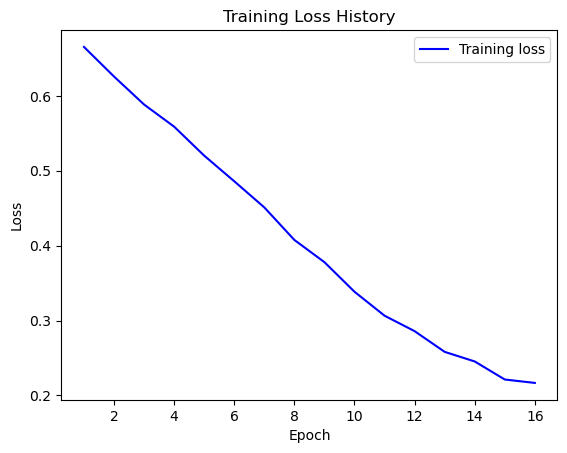

In [15]:
import matplotlib.pyplot as plt

# Create a list of epochs
epochs = range(1, len(loss_hist) + 1)

# Plot the training loss as a curve
plt.plot(epochs, loss_hist, 'b-', label='Training loss')

# Add a title and axis labels
plt.title("Training Loss History")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [16]:
# path warning!! Colab dir are different
prog_tensors_test = torch.load('./test-tensors/progressive_rock_songs_test_tensor.pt')
non_prog_tensors_test = torch.load('./test-tensors/non_progressive_rock_songs_test_tensor.pt')
# model/model_conv1d_norm_1_large.pt

In [17]:
# model = model_state_dict
model.eval()  # Set the model to evaluation mode
## For the song
device = get_device()
model.to("cpu")
prog_true = 0
prog_false = 0
non_prog_true = 0
non_prog_false = 0
# for the individual snippets
total_prog_true = 0
total_prog_false = 0
total_non_prog_true = 0
total_non_prog_false = 0
with torch.no_grad():  # Disable gradients during validation
  correct = 0
  total = 0
  for obj in prog_tensors_test:
    total = len(obj)
    it = 0
    for i in obj:
      i = i.reshape(1,160,216)
      i = i.to("cpu")
      outputs = model(i)
      _, predicted = torch.max(outputs.data, 1)
      # print(predicted)
      if(predicted.item() == 1):
        it = it+1
    
    total_prog_true += it
    total_prog_false += (total-it)
    if(2*it >= total):
      prog_true +=1
    else:
      prog_false +=1
  for obj in non_prog_tensors_test:
    total = len(obj)
    it = 0
    for i in obj:
      i = i.reshape(1,160,216)
      outputs = model(i)
      _, predicted = torch.max(outputs.data, 1)
      # print(predicted)
      if(predicted.item() == 0):
        it = it+1
    total_non_prog_true += it
    total_non_prog_false += (total-it)
    if(2*it >= total):
      non_prog_true +=1
    else:
      non_prog_false +=1


print(prog_true, prog_false)
print(non_prog_false, non_prog_true)

print(total_prog_true, total_prog_false)
print(total_non_prog_false, total_non_prog_true)

128 10
48 85
4812 1903
1840 2172


In [18]:
TP = prog_true
FN = prog_false
FP = non_prog_false
TN = non_prog_true

# Calculate Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Calculate Precision for the progressive class
precision = TP / (TP + FP)

# Calculate Recall (Sensitivity) for the progressive class
recall = TP / (TP + FN)

# Calculate Specificity for the progressive class
specificity = TN / (TN + FP)

# Calculate F1 Score for the progressive class
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the results
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision (Progressive Class): {precision:.4f}")
print(f"Recall (Progressive Class): {recall:.4f}")
print(f"Specificity (Progressive Class): {specificity:.4f}")
print(f"F1 Score (Progressive Class): {f1_score:.4f}")

Accuracy: 78.60%
Precision (Progressive Class): 0.7273
Recall (Progressive Class): 0.9275
Specificity (Progressive Class): 0.6391
F1 Score (Progressive Class): 0.8153
